In [132]:
#importing necessary libraries
from keras.datasets import cifar100
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [133]:
# loading the dataset
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
#generating the validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42,stratify=y_train)

In [136]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 10

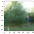

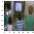

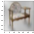

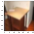

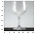

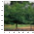

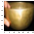

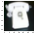

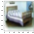

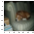

In [137]:
#selecting insects (cockroach),television,chair,table,cups,tree,bowl,telephone,bed,couch labels (eye balling)
selects = [59,87,20,84,28,47,10,86,5,25]
for select in selects:
  
  plt.imshow(X_train[np.where(y_train == select)[0][1]])
  plt.show()


In [75]:
#labels of selected classes are stored in labels
selects = [59,87,20,84,28,47,10,86,5,25]
x_data = list()
y_data = list()
for select in selects:
  x_data.extend(X_train[np.where(y_train == select)[0]])
  y_data.extend(y_train[np.where(y_train == select)[0]])
x_train = np.asarray(x_data)
y_train = np.asarray(y_data) 

x_data = list()
y_data = list()
for select in selects:
  x_data.extend(X_val[np.where(y_val == select)[0]])
  y_data.extend(y_val[np.where(y_val == select)[0]])
x_val = np.asarray(x_data)
y_val = np.asarray(y_data) 


x_data = list()
y_data = list()
for select in selects:
  x_data.extend(X_test[np.where(y_test == select)[0]])
  y_data.extend(y_test[np.where(y_test == select)[0]])
x_test = np.asarray(x_data)
y_test = np.asarray(y_data)   


  

In [77]:
BATCH_SIZE = 32
IMG_SIZE = (96, 96)

In [78]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [79]:
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

In [80]:
base_model.trainable = False

In [81]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
prediction_layer = tf.keras.layers.Dense(10,activation = 'softmax')

In [82]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [83]:

height = 96
width = 96
resize = tf.keras.layers.experimental.preprocessing.Resizing(
    height, width, interpolation='bilinear', name=None)


In [84]:
inputs = tf.keras.Input(shape=(32, 32, 3))

x = resize(inputs)
x = preprocess_input(x)

x = base_model(x, training=False)
x = global_average_layer(x)

outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [85]:
#final model with frozen weights from mobile net v2
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resizing_1 (Resizing)        (None, 96, 96, 3)         0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf_op_layer_Sub_1 (TensorFlo [(None, 96, 96, 3)]       0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)               

In [86]:
from sklearn import preprocessing
from keras.utils import np_utils
# encode class values as integers
encoder = preprocessing.LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_Y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [87]:
# encode class values as integers
encoder = preprocessing.LabelEncoder()
encoder.fit(y_val)
encoded_Y = encoder.transform(y_val)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_val = np_utils.to_categorical(encoded_Y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [88]:
base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [97]:
print("Fit model on training data")
history = model.fit(
    x_train , dummy_y_train,
    batch_size=64,
    epochs=10,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, dummy_y_val)
)


Fit model on training data
Epoch 1/10
63/63 [==============================] - 28s 444ms/step - loss: 0.3202 - accuracy: 0.8905 - val_loss: 0.8614 - val_accuracy: 0.7770
Epoch 2/10
63/63 [==============================] - 28s 444ms/step - loss: 0.2078 - accuracy: 0.9273 - val_loss: 0.7726 - val_accuracy: 0.7960
Epoch 3/10
63/63 [==============================] - 28s 446ms/step - loss: 0.1151 - accuracy: 0.9625 - val_loss: 0.8062 - val_accuracy: 0.7940
Epoch 4/10
63/63 [==============================] - 28s 445ms/step - loss: 0.0675 - accuracy: 0.9772 - val_loss: 0.8298 - val_accuracy: 0.7950
Epoch 5/10
63/63 [==============================] - 28s 445ms/step - loss: 0.0578 - accuracy: 0.9820 - val_loss: 0.8303 - val_accuracy: 0.8000
Epoch 6/10
63/63 [==============================] - 28s 446ms/step - loss: 0.0440 - accuracy: 0.9885 - val_loss: 0.8654 - val_accuracy: 0.7900
Epoch 7/10
63/63 [==============================] - 28s 444ms/step - loss: 0.0240 - accuracy: 0.9970 - val_loss: 0.

In [99]:
# encode class values as integers
encoder = preprocessing.LabelEncoder()
encoder.fit(y_test)
encoded_Y = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


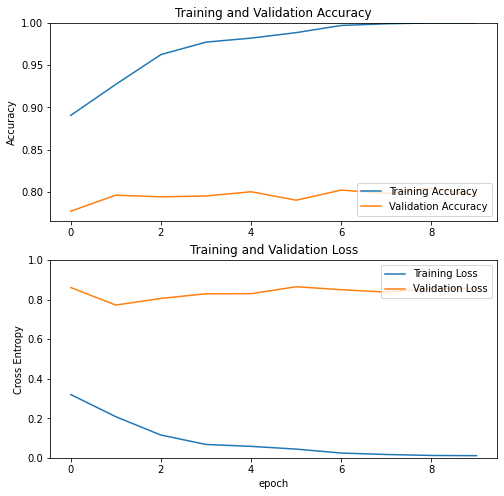

In [101]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [95]:
# Calling `save('my_model')` creates a SavedModel folder `my_model`.
model.save("my_model")


INFO:tensorflow:Assets written to: my_model/assets


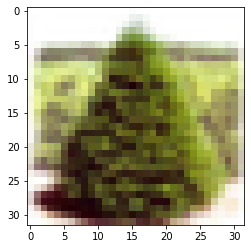

In [116]:
plt.imshow(x_test[10])

In [122]:
predictions = model.predict(x_test)
predictions = tf.where(predictions < 0.5, 0, 1)
print('Predictions:\n', predictions.numpy())

Predictions:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [128]:
#performance evaluation in test datasets
from sklearn.metrics import classification_report


print(classification_report(dummy_y_test, predictions))

              precision    recall  f1-score   support

           0       0.70      0.65      0.67       100
           1       0.81      0.79      0.80       100
           2       0.83      0.80      0.82       100
           3       0.66      0.65      0.66       100
           4       0.90      0.86      0.88       100
           5       0.77      0.85      0.81       100
           6       0.83      0.73      0.78       100
           7       0.73      0.72      0.73       100
           8       0.84      0.84      0.84       100
           9       0.90      0.95      0.93       100

   micro avg       0.80      0.78      0.79      1000
   macro avg       0.80      0.78      0.79      1000
weighted avg       0.80      0.78      0.79      1000
 samples avg       0.78      0.78      0.78      1000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
